In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

In [2]:
class MultipleLinearRegression:
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None
        self.X = None
        self.y = None
        self.y_pred = None
        self.n = None
        self.k = None

    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y).reshape(-1, 1)
        self.n, self.k = self.X.shape

        X_b = np.c_[np.ones((self.n, 1)), self.X]

        beta = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ self.y

        self.intercept_ = beta[0, 0]
        self.coef_ = beta[1:].flatten()

        self.y_pred = X_b @ beta

    def predict(self, X):
        X = np.array(X)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b @ np.r_[self.intercept_, self.coef_].reshape(-1, 1)

    def plot(self):
        if self.k != 2:
            raise ValueError("3D plot only works with exactly 2 features")

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

        x1 = self.X[:, 0]
        x2 = self.X[:, 1]
        y = self.y.flatten()

        ax.scatter(x1, x2, y, c='r', marker='o', alpha=0.6, label="Data")

        x1_grid, x2_grid = np.meshgrid(np.linspace(min(x1), max(x1), 20),
                                       np.linspace(min(x2), max(x2), 20))
        y_grid = (self.intercept_ + self.coef_[0] * x1_grid + self.coef_[1] * x2_grid)

        ax.plot_surface(x1_grid, x2_grid, y_grid, alpha=0.5, color='blue')
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")
        ax.set_zlabel("Y")
        plt.title("Multiple Linear Regression (3D)")
        plt.legend()
        plt.show()

    def anova(self):
        y_mean = np.mean(self.y)
        
        SST = np.sum((self.y - y_mean) ** 2)
        SSR = np.sum((self.y_pred - y_mean) ** 2)
        SSE = np.sum((self.y - self.y_pred) ** 2)

        df_reg = self.k
        df_err = self.n - self.k - 1
        df_tot = self.n - 1

        MSR = SSR / df_reg
        MSE = SSE / df_err

        F = MSR / MSE

        anova_table = pd.DataFrame({
            'SS': [SSR, SSE, SST],
            'df': [df_reg, df_err, df_tot],
            'MS': [MSR, MSE, 'NaN'],
            'F': [F, 'NaN', 'NaN']
        }, index=['Regression', 'Error', 'Total'])

        return anova_table

    def hypothesis_test(self):
        # إعداد البيانات
        X_b = np.c_[np.ones((self.n, 1)), self.X]
        beta = np.r_[self.intercept_, self.coef_].reshape(-1, 1)
    
        # حساب SSE و MSE
        residuals = self.y - self.y_pred
        SSE = np.sum(residuals**2)
        MSE = SSE / (self.n - self.k - 1)
    
        # (X^T X)^(-1)
        var_beta = MSE * np.linalg.inv(X_b.T @ X_b)
    
        # Standard Errors
        se = np.sqrt(np.diag(var_beta))
    
        # t-statistics
        t_stats = beta.flatten() / se
    
        # p-values (two-tailed)
        p_values = [2 * (1 - stats.t.cdf(abs(t), df=self.n - self.k - 1)) for t in t_stats]
    
        # جدول النتائج
        results = pd.DataFrame({
            "Coefficient": beta.flatten(),
            "Std Error": se,
            "t-stat": t_stats,
            "p-value": p_values
        }, index=["Intercept"] + [f"X{i+1}" for i in range(self.k)])
    
        return results


In [3]:
# 1) قراءة الداتا
df = pd.read_csv("D:\Regression\Sections\income.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Regression\\Sections\\income.csv'

In [ ]:
df.head()

,age,experience,income
0,25,1,30450
1,30,3,35670
2,47,2,31580
3,32,5,40130
4,43,10,47830


In [ ]:
# 2) فصل الـ features و الـ target
X = df[["age", "experience"]].values
y = df["income"].values

In [ ]:
# 3) استدعاء الكلاس وتدريب الموديل
model = MultipleLinearRegression()
model.fit(X, y)

In [ ]:
# 4) عرض النتائج
print("Intercept (beta0):", model.intercept_)
print("Coefficients (betas):", model.coef_)

Intercept (beta0): 31261.68985410184
Coefficients (betas): [ -99.19535546 2162.40419192]


In [ ]:
# 5) مثال للتنبؤ
example = [[40, 8]]   # شخص عمره 40 سنة وخبرته 8 سنوات
print("Predicted Income for (40, 8):", model.predict(example)[0][0])

Predicted Income for (40, 8): 44593.109171052165


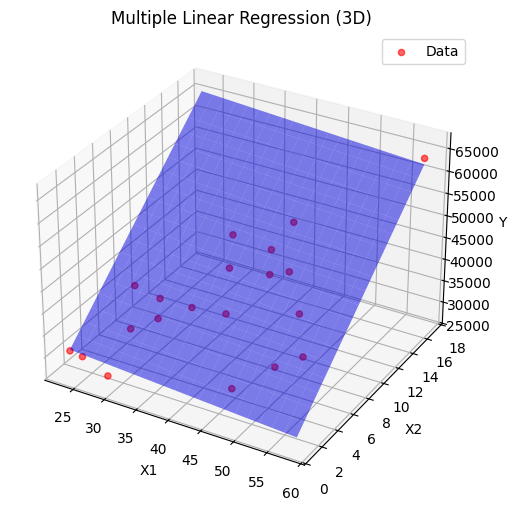

In [ ]:
# 6) رسم ثلاثي الأبعاد
model.plot()

In [ ]:
# 7) جدول ANOVA
anova_table = model.anova()
print("\nANOVA Table:")
print(anova_table)


ANOVA Table:
                      SS  df                MS           F
Regression  1.322701e+09   2  661350407.712852  366.546291
Error       3.067268e+07  17    1804275.269076         NaN
Total       1.353373e+09  19               NaN         NaN


In [ ]:
ht = model.hypothesis_test()
print(ht)